# Repeat until success

## Background

This tutorial demonstrates how certain IBM Quantum&trade; systems (those that support dynamic circuits) use mid-circuit measurements to produce a circuit that repeatedly attempts its setup until a syndrome measurement reveals that it has been successful.

You will build an abstract circuit that uses the non-parametrized gate set $\{H,\,X,\,S,\,\text{Toffoli}\}$ to construct a heralded $R_X(\theta)$ gate on a target qubit, where $\theta$ satisfies $\cos\theta = \frac35$. Each iteration of the circuit has a finite chance of success, but because successes are heralded, dynamic circuit capabilities are used to repeat the setup until it succeeds.

## Setup

In [1]:
# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

## Build problem

A single trial of the probabalistic gate has the following form:

In [2]:
controls = QuantumRegister(2, name="control")
target = QuantumRegister(1, name="target")

mid_measure = ClassicalRegister(2, name="mid")
final_measure = ClassicalRegister(1, name="final")

circuit = QuantumCircuit(controls, target, mid_measure, final_measure)

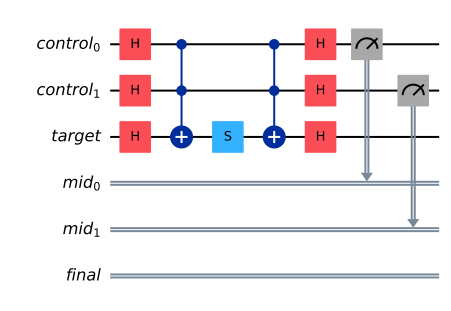

In [3]:
def trial(circuit, target, controls, measures):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.h(target)
    circuit.h(controls)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)
    circuit.measure(controls, measures)

trial(circuit, target, controls, mid_measure)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

If _both_ control bit measurements return $0$, the gate $R_X(\theta)$ with $\cos\theta = \frac35$ is applied.  If any of the measurements are $1$, gate $X$ is applied, which is a failure.  This is the heralding; you can tell from the measurement whether the correct gate was applied, without disturbing the coherence of the target qubit.  Without fully reproducing the mathematics, the success probability of this gate is:
$$
P_{\text{success}} = \frac{
{|3 + i|}^2
}
{
{|3 + i|}^2 + 3{|1 - i|}^2
}
= \frac58
$$

If there is a failure, you should reset the "dirty" state and start again.  Because you know what is applied in the case of a failure, you can use this knowledge to perform the reset efficiently without using a general hardware reset.  For the two auxiliary qubits, this is an $X$ gate conditioned on its respective measurement being $1$.  IBM&reg; hardware has a special fast path for when qubits are conditioned on the result of their own measurement, so this is more efficient than most control flows.

In [4]:
def reset_controls(circuit, controls,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])

Qiskit cannot directly represent an inequality condition, which is required for this exercise. You only need to repeat if the mid-circuit measurement result was not the bitstring `"00"`.  Instead, you can create an `if` statement with the condition `mid_measure == "00"`, pass an empty block, and then use the `else` branch to perform the necessary logic.

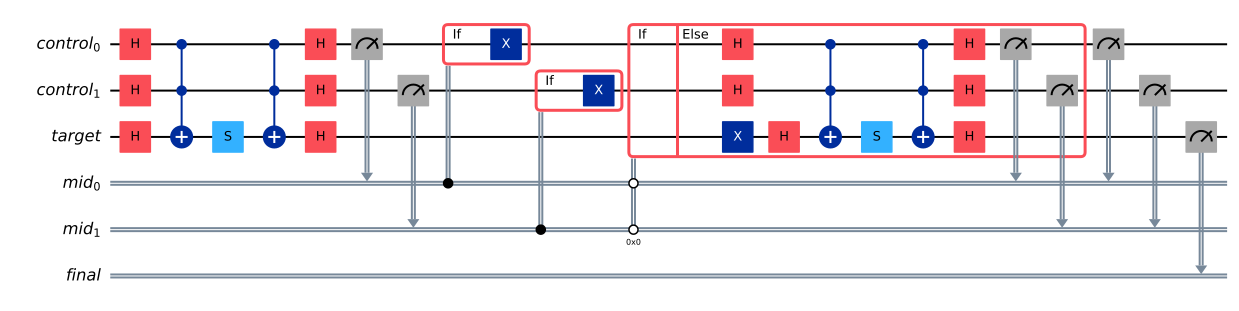

In [5]:
max_trials = 2

# Manually add the rest of the trials.  In the future, you can
# use a dynamic `while` loop to do this, but for now,
# statically add each loop iteration with a manual condition check
# on each one.  This involves more classical synchronizations than
# the while loop, but will suffice for now.
for _ in range(max_trials - 1):
    reset_controls(circuit, controls, mid_measure)
    with circuit.if_test((mid_measure, 0b00)) as else_:
        # This is the success path, but Qiskit can't directly
        # represent a negative condition yet, so we have an
        # empty `true` block in order to use the `else` branch.
        pass
    with else_:
        # First reset the target.
        circuit.x(target)
        # Then repeat the trial.
        trial(circuit, target, controls, mid_measure)

# Measure the control qubits again to ensure you
# get their final results; this is a hardware limitation.
circuit.measure(controls, mid_measure)

# Finally, measure the target, to check that you're
# getting the desired rotation.
circuit.measure(target, final_measure)

circuit.draw(output="mpl", style='iqp', cregbundle=False)

## Run in local testing mode

In [6]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# Run the sampler job locally using FakeSherbrooke
backend = FakeSherbrooke()

### Convert to ISA input

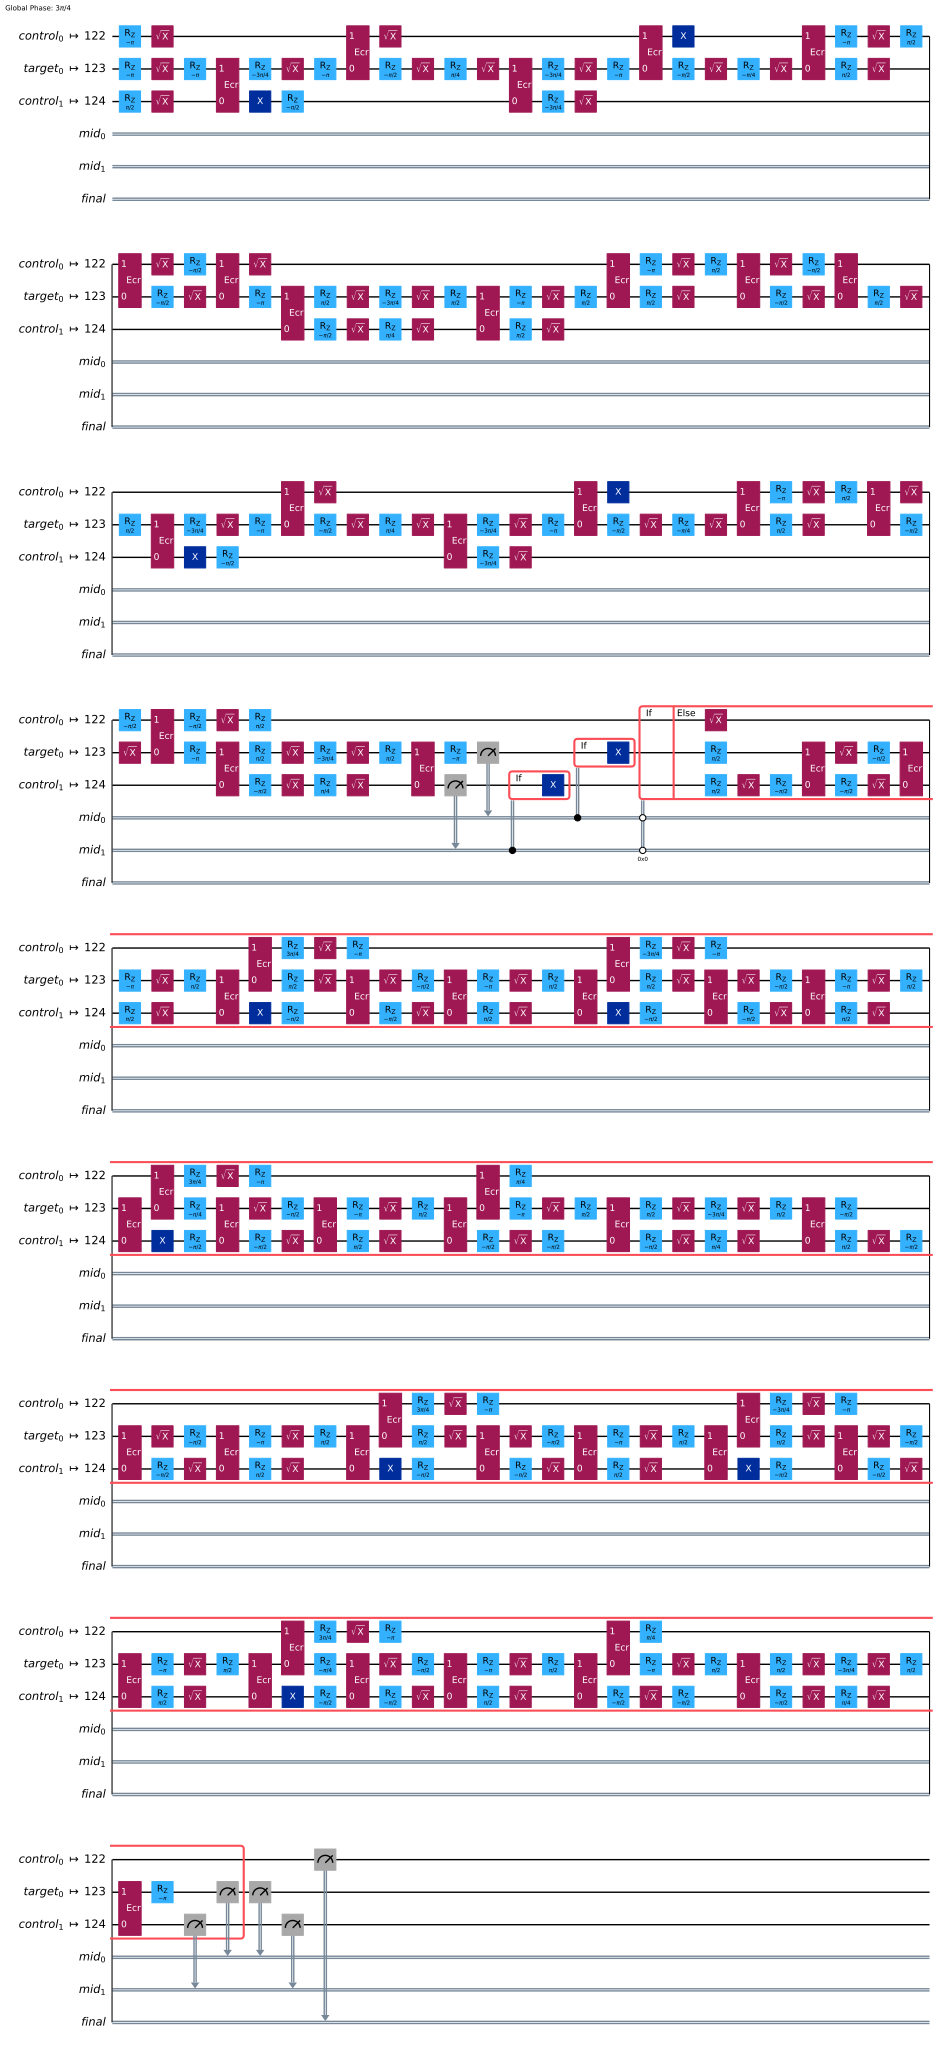

In [7]:
# Circuits must obey the Instruction Set Architecture (ISA) of a particular backend.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

### Run the job

In [8]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit])

simulator_counts = job.result()[0]
print(f">>> Simulator counts for mid: {simulator_counts.data.mid.get_counts()}")
print(f">>> Simulator counts for final: {simulator_counts.data.final.get_counts()}")

>>> Simulator counts for mid: {'00': 804, '10': 71, '01': 63, '11': 86}
>>> Simulator counts for final: {'0': 696, '1': 328}


## Run on IBM hardware

In [9]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f">>> Connected to {backend.name} backend.")

>>> Connected to ibm_kyiv backend.


### Convert to ISA input

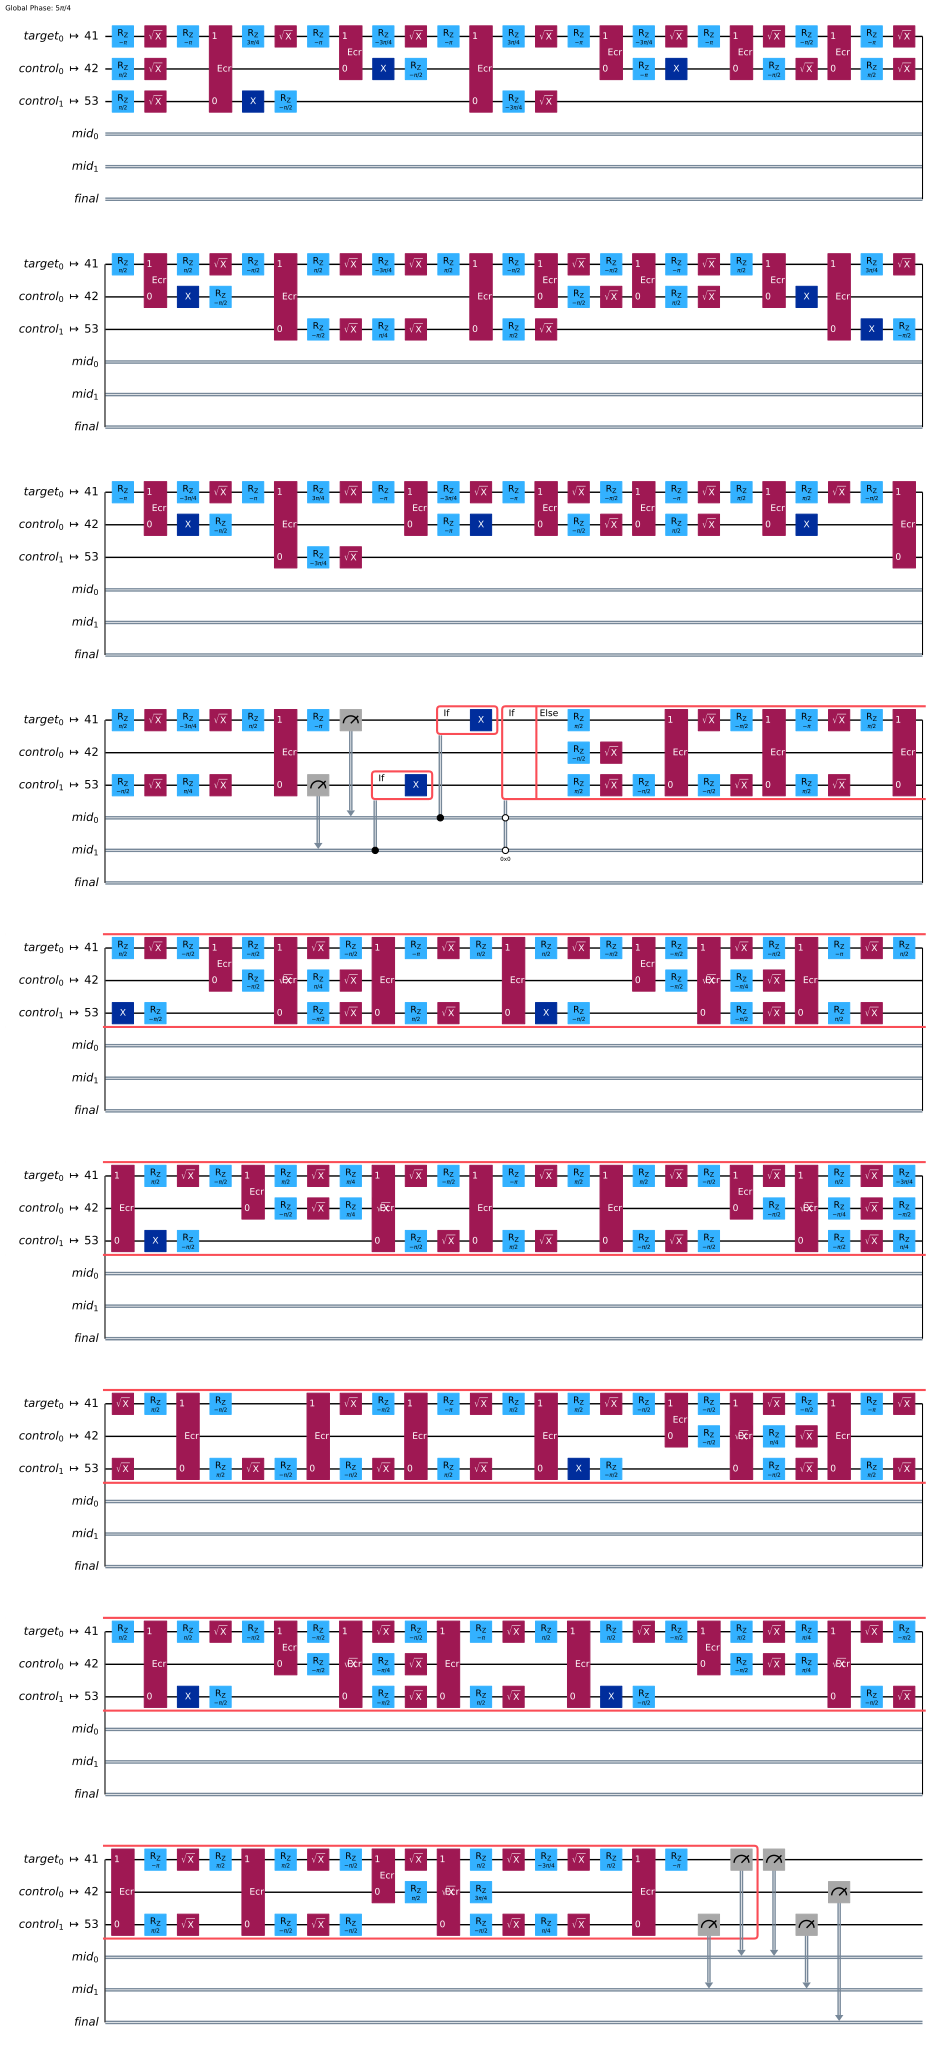

In [10]:
# Circuits must obey the ISA of a particular backend.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw(output="mpl", style='iqp', idle_wires=False, cregbundle=False)

### Run the job

In [11]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
job.job_id()

'crh9kwzx30tg008kmm4g'

In [12]:
hardware_counts = job.result()[0]

data_mid = job.result()[0].data.mid
data_final = job.result()[0].data.final

print(f">>> Hardware counts for mid: {data_mid.get_counts()}")
print(f">>> Hardware counts for final: {data_final.get_counts()}")

>>> Hardware counts for mid: {'00': 3165, '01': 322, '10': 296, '11': 313}
>>> Hardware counts for final: {'1': 1505, '0': 2591}


In [13]:
from collections import defaultdict

merged_data = defaultdict(int)
for bs1, bs2 in zip(data_mid.get_bitstrings(), data_final.get_bitstrings()):
    merged_data[f"{bs1}-{bs2}"] += 1

print(f">>> Hardware merged data: {dict(merged_data)}")

>>> Hardware merged data: {'00-1': 993, '01-0': 147, '00-0': 2172, '10-0': 127, '10-1': 169, '11-0': 145, '11-1': 168, '01-1': 175}


## Analyze the results

A successful result is one in which the measurements on the two controls end in the `00` state.  You can filter those out and see how many successes will result.  This is a type of post-selection.  In the complete repeat-until-success circuit with a dynamic `while` loop, this would not be necessary, as you would be guaranteed a success.  However, in the interim, you can use the probabilities to examine the quality of the output and verify that the probabilities are as expected.

In [14]:
def marginalize_successes(counts):
    """Split the full output `counts` dictionary
    into two separate dictionaries, marginalizing
    the results to leave only the target qubit's
    state."""
    successes = defaultdict(int)
    failures = defaultdict(int)

    for key, value in counts.items():
        if key.startswith("00"):
            successes[key[-1]] += value
        else:
            failures[key[-1]] += value

    return successes, failures

In [15]:
hw_successes, hw_failures = marginalize_successes(merged_data)

expected_successes = 1 - (1 - 5/8)**max_trials
actual_successes = sum(hw_successes.values()) / sum(merged_data.values())
print(f"Expected success rate {expected_successes:5.3f}.  Actual rate {actual_successes:5.3f}.")

Expected success rate 0.859.  Actual rate 0.773.


We can also test the post-selected output state:

In [16]:
actual_probability = hw_successes["1"] / sum(hw_successes.values())
print(f"Expected |1> probability: 0.2.  Actual probability {actual_probability:5.3f}.")

Expected |1> probability: 0.2.  Actual probability 0.314.


In [17]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.22.0'

In [18]:
import qiskit

qiskit.version.get_version_info()

'1.0.2'